# Preprocess the block-slide image pair before the QC step

### Import the necessary libraries

In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Helper Functions
from helpers import *

### Functions

In [2]:
def crop(image, x1, x2, y1, y2):
    height = image.shape[0]
    width = image.shape[1]
    cropped = image[y1:y2, x1:x2]
    return cropped.copy()


def flip_img(img, direction):
    return cv2.flip(img, direction).copy()


def resize_with_pad(image, height=1500, width=1500):

    def get_padding_size(image):
        try:
            h, w, _ = image.shape
        except:
            h, w = image.shape
        longest_edge = max(h, w)
        top, bottom, left, right = (0, 0, 0, 0)
        if h < longest_edge:
            dh = longest_edge - h
            top = dh // 2
            bottom = dh - top
        elif w < longest_edge:
            dw = longest_edge - w
            left = dw // 2
            right = dw - left
        else:
            pass
    
        return top+100, bottom+100, left+100, right+100

    top, bottom, left, right = get_padding_size(image)
    BLACK = [0, 0, 0]
    constant = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=BLACK)

    resized_image = cv2.resize(constant, (height, width))

    return resized_image

In [3]:
# Read all images
import os

slides = []
blocks = []

path = './img_raw/blocks/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_blk = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    blocks.append(img_blk)

path = './img_raw/slides/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_sld = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    slides.append(img_sld)

### Preprocess function
* The functions take in the block-slide image pair, and return the processed block-slide image pair.
* The following must be corrected:
    1. Orientations
    2. Cropping
    3. Colour correction (RGB to Grayscale)

In [6]:
def kmean_segmentation(image, K, attempts):

    vectorized = image.reshape((-1, 3)).copy()
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    ret, label, center = cv2.kmeans(
        vectorized, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    image_kmean = res.reshape((image.shape))

    return image_kmean.copy()


def adaptive_thresholding(image_gray):
    # blur and grayscale before thresholding
    k = 9
    blur = cv2.GaussianBlur(
        src=image_gray,
        ksize=(k, k),
        sigmaX=0)

    # perform adaptive thresholding
    (t, image_thres) = cv2.threshold(src=blur,
                                     thresh=0,
                                     maxval=255,
                                     type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return image_thres.copy()


def get_contours(image, image_thres):
    image_with_cnts = image.copy()

    image_thres = cv2.erode(image_thres, None, iterations=2)
    image_thres = cv2.dilate(image_thres, None, iterations=2)

    cnts = cv2.findContours(image_thres, cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)[1]
    cv2.drawContours(image_with_cnts, cnts, -1, (0, 255, 255), 5)

    return image_with_cnts, cnts


def crop_by_contour(image, cnts):
    min_area = 30000
    max_area = 2000000
    box = np.zeros(shape=image.shape, dtype="uint8")
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area and area < max_area:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(img=box,
                          pt1=(x, y),
                          pt2=(x + w, y + h),
                          color=(255, 255, 255),
                          thickness=-1)

    boxed = cv2.bitwise_and(src1=image, src2=box)
    image_cropped = image[y:y+h, x:x+w]

    return box, boxed, image_cropped

In [4]:
image = slides[5].copy()

image = crop(image, 310, 2690, 1080, 2320)

image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Adaptive thresholding
image_thres = adaptive_thresholding(image_gray)
image_thres = cv2.erode(image_thres, None, iterations=10)
# image_thres = cv2.dilate(image_thres, None, iterations=10)
show1img(image_thres, "thres")

image_thres_bw = cv2.merge(mv=[image_thres, image_thres, image_thres])

# contours, hierarchy = cv2.findContours(image_thres,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
cnts = cv2.findContours(image_thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]

image_with_cnts = image_thres_bw.copy()
cv2.drawContours(image_with_cnts, cnts, 2, (0, 0, 0), -1)

show1img(image_with_cnts, "image_with_cnts")

NameError: name 'adaptive_thresholding' is not defined

In [75]:
def preprocess_slide(img_slide, if_print):
    image = crop(img_slide, 310, 2690, 1080, 2320)

    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Adaptive thresholding
    image_thres = adaptive_thresholding(image_gray)
    image_thres = 255 - image_thres

    # Make a mask suitable for color images
    image_thres_bw = cv2.merge(mv=[image_thres, image_thres, image_thres])

    image = resize_with_pad(image, height=1500, width=1500)
    image_thres = resize_with_pad(image_thres, height=1500, width=1500)
    image_thres_bw = resize_with_pad(image_thres_bw, height=1500, width=1500)
    
    # Use the mask to select the remove background
    image_noBg = cv2.bitwise_and(src1=image, src2=image_thres_bw)
    image_noBg[image_noBg == 0] = 0

    image_with_cnts, cnts = get_contours(image_thres_bw, image_thres)
    
    # Find largest bounding rectangle
    box, boxed, image_cropped = crop_by_contour(image_thres_bw, cnts)
    image_gray_box = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
    # Adaptive thresholding
    image_thres_box = adaptive_thresholding(image_gray_box)

    # make a mask suitable for color images
    image_thres_bw_box = cv2.merge(
        mv=[image_thres_box, image_thres_box, image_thres_box])
    image_thres_bw_box = 255 - image_thres_bw_box

    image_with_cnts_box, cnts_box = get_contours(box, image_thres_box)
    new_box, new_boxed, image_out = crop_by_contour(image_thres_bw, cnts_box)

    image_out = flip_img(flip_img(image_out, 0), -1)
    image_out = resize_with_pad(image_out, height=1500, width=1500)

    if if_print:
        show1img(image, 'original')
        show1img(image_thres, 'Threshold image')
        show1img(image_thres_bw, 'bw Threshold image')
        show1img(image_noBg, 'Removed background')
        show1img(image_with_cnts, 'contour')
        show1img(box, 'box')
        show1img(image_thres_box, 'Threshold image')
        show1img(image_thres_bw_box, 'bw Threshold image')
        show1img(image_with_cnts_box, 'contour')
        show1img(new_box, 'box')
        show1img(new_boxed, 'boxed')
        show1img(image_out, 'image_cropped')

    return image_out

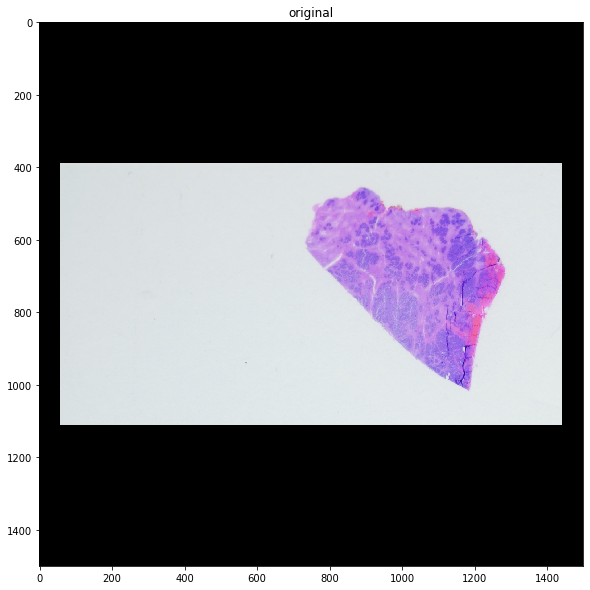

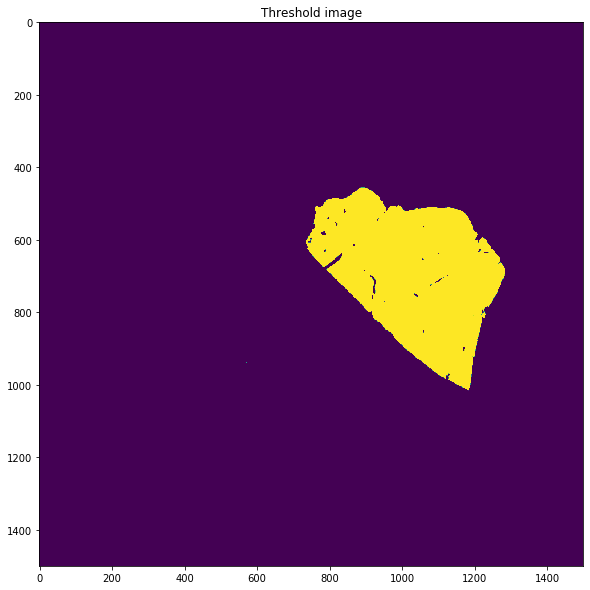

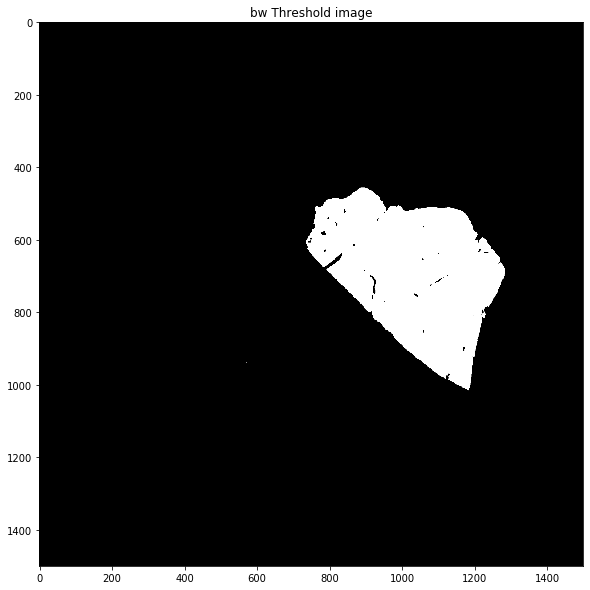

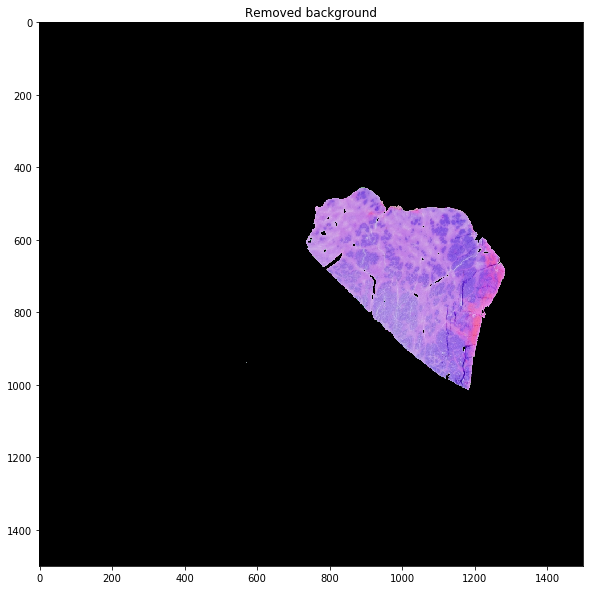

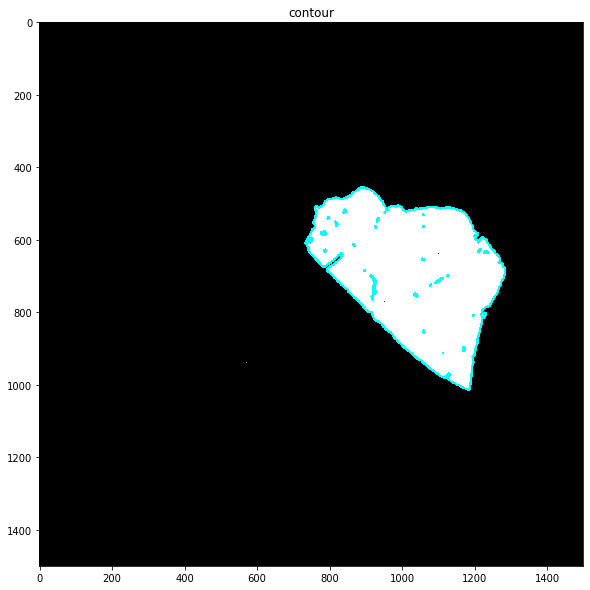

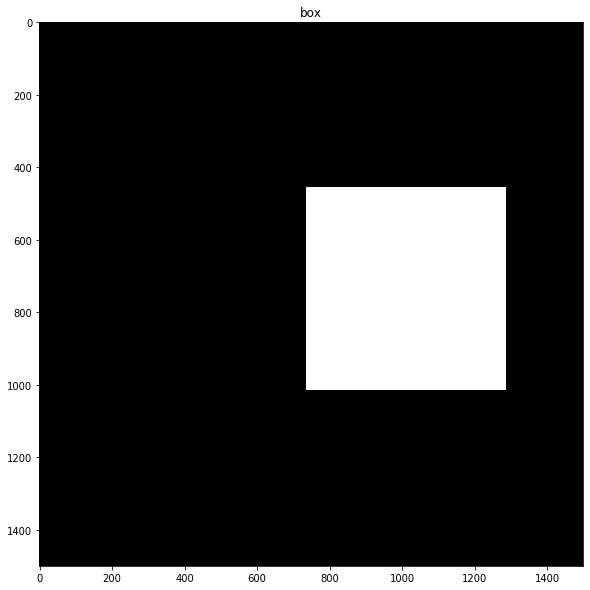

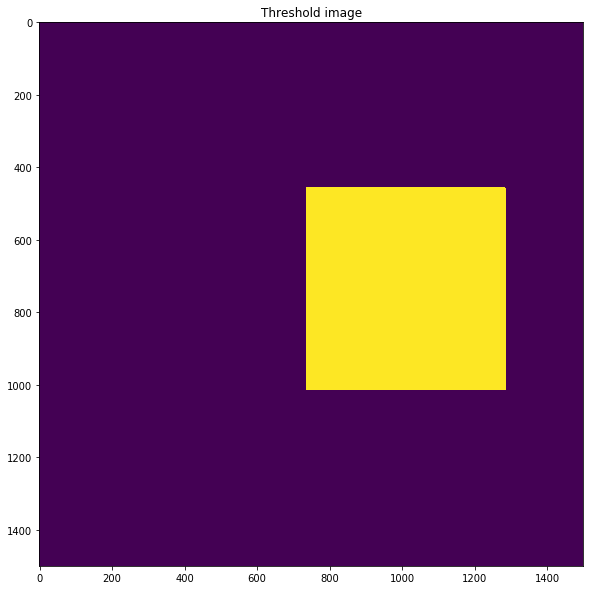

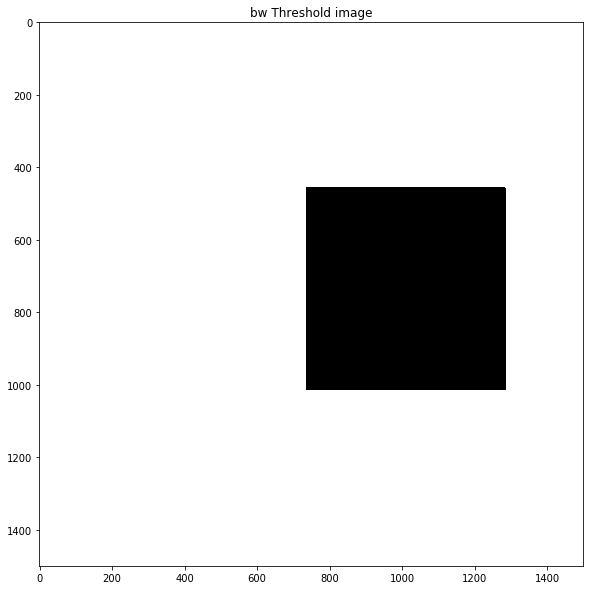

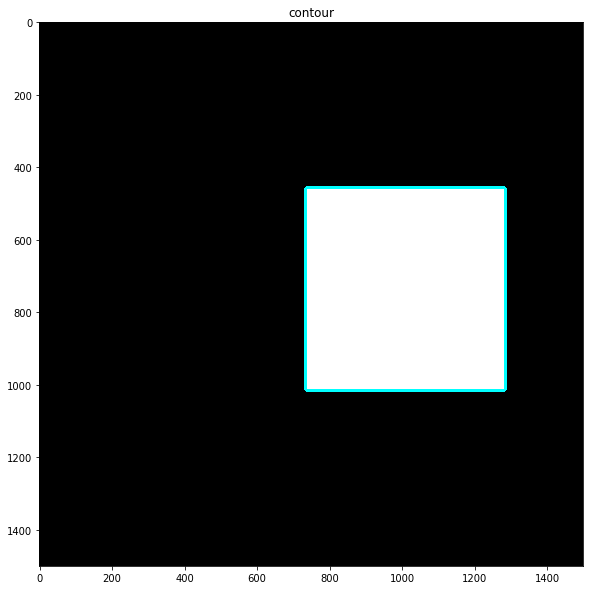

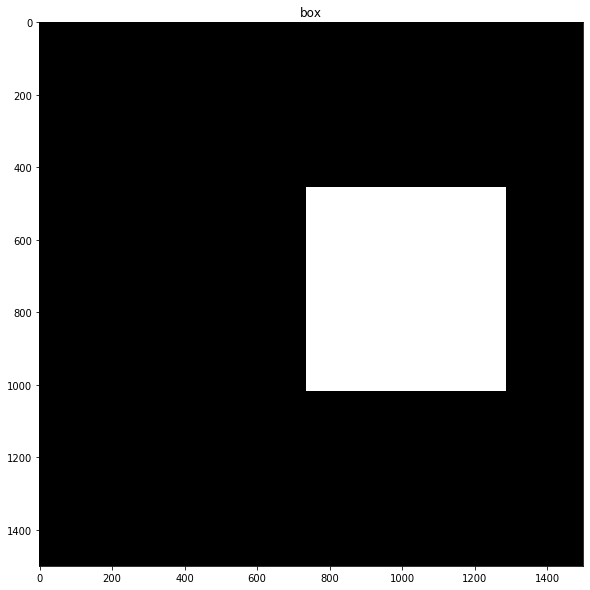

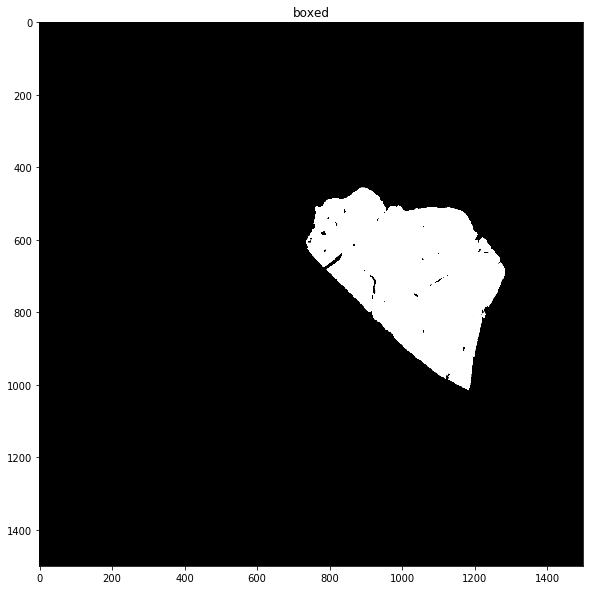

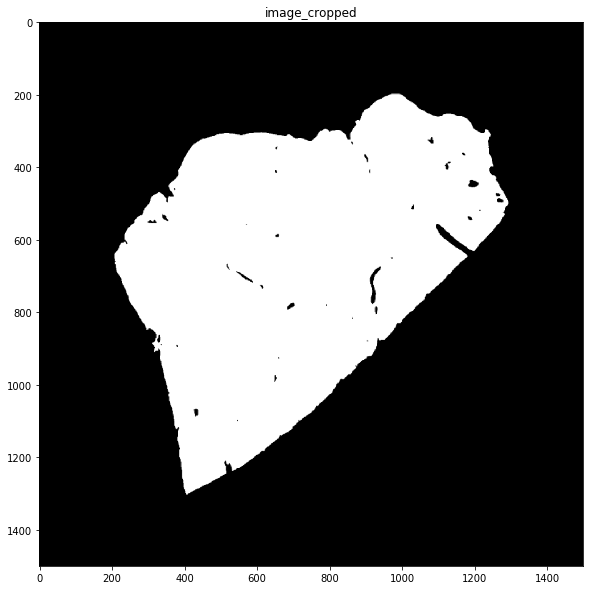

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [76]:
preprocess_slide(slides[5].copy(), True)

In [9]:
def preprocess_block(img_block, if_print):
    image = crop(img_block, 1300, 3200, 1000, 2300)

    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Adaptive thresholding
    image_thres = adaptive_thresholding(image_gray)
    image_thres = 255 - image_thres

    # Make a mask suitable for color images
    image_thres_bw = cv2.merge(mv=[image_thres, image_thres, image_thres])
    
    image_binary = image_thres_bw

    image = resize_with_pad(image, height=1500, width=1500)
    image_thres = resize_with_pad(image_thres, height=1500, width=1500)
    image_binary = resize_with_pad(image_binary, height=1500, width=1500)

    # Use the mask to select the remove background
    image_noBg = cv2.bitwise_and(src1=image, src2=image_binary)
    image_noBg[image_noBg == 0] = 255

    image_with_cnts, cnts = get_contours(image_binary, image_thres)

    # Find largest bounding rectangle
    box, boxed, image_cropped = crop_by_contour(image_binary, cnts)
    image_gray_box = cv2.cvtColor(box, cv2.COLOR_RGB2GRAY)
    # Adaptive thresholding
    image_thres_box = adaptive_thresholding(image_gray_box)

    # make a mask suitable for color images
    image_thres_bw_box = cv2.merge(
        mv=[image_thres_box, image_thres_box, image_thres_box])

    image_with_cnts_box, cnts_box = get_contours(box, image_thres_box)
    new_box, new_boxed, image_out = crop_by_contour(image_binary, cnts_box)

    image_out = resize_with_pad(image_out, height=1500, width=1500)

    if if_print:
        show1img(image, 'original')
        show1img(image_thres, 'Threshold image')
        show1img(image_thres_bw, 'bw Threshold image')
        show1img(image_noBg, 'Removed background')
        show1img(image_with_cnts, 'contour')
        show1img(box, 'box')
        show1img(image_thres_box, 'Threshold image')
        show1img(image_thres_bw_box, 'bw Threshold image')
        show1img(image_with_cnts_box, 'contour')
        show1img(new_box, 'box')
        show1img(new_boxed, 'boxed')
        show1img(image_out, 'image_cropped')

    return image_out

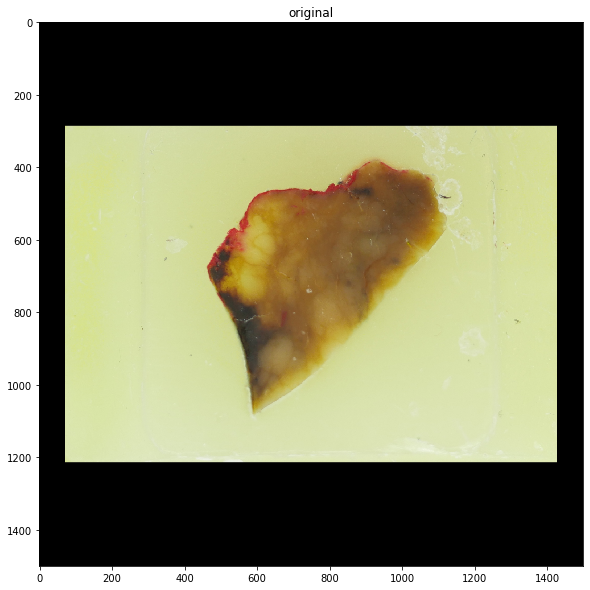

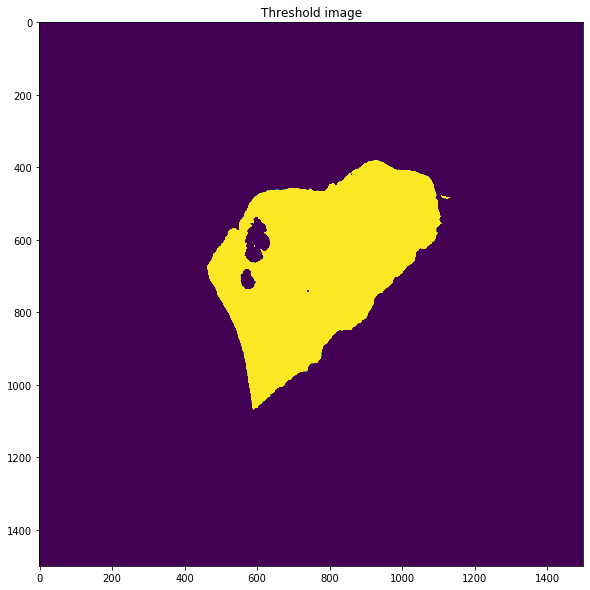

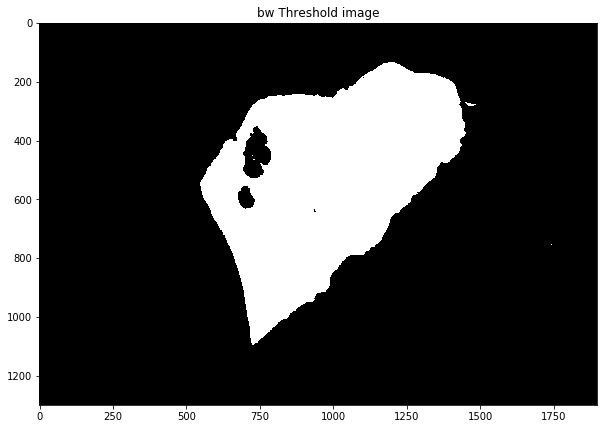

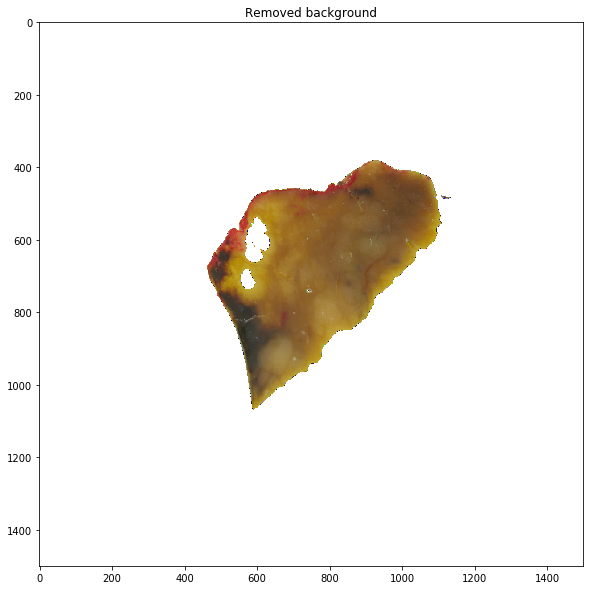

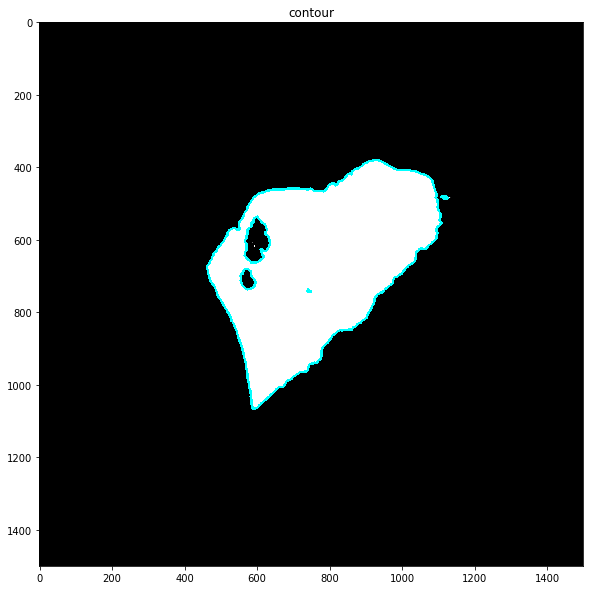

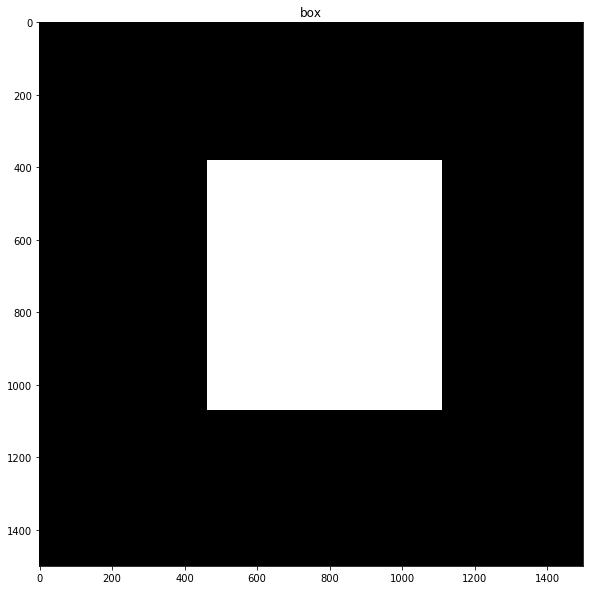

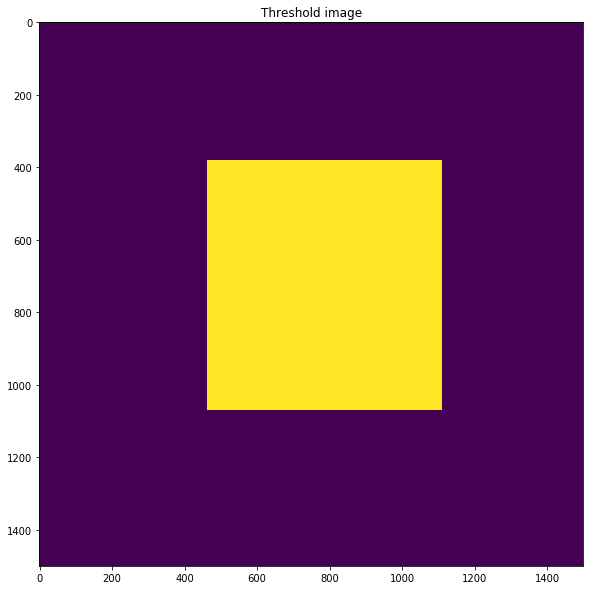

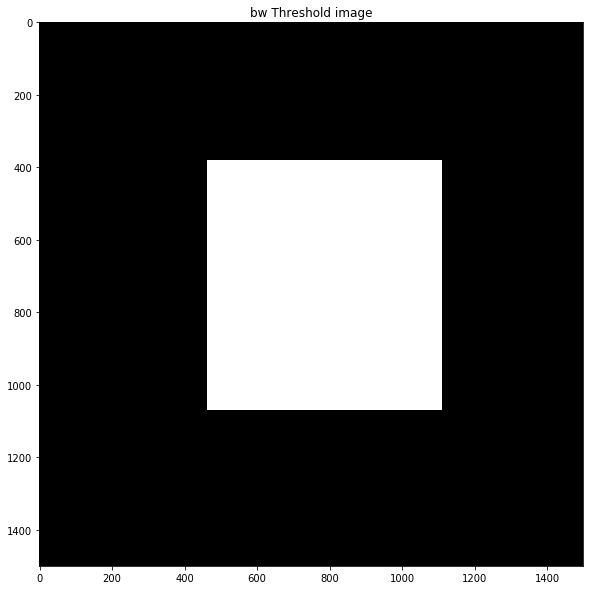

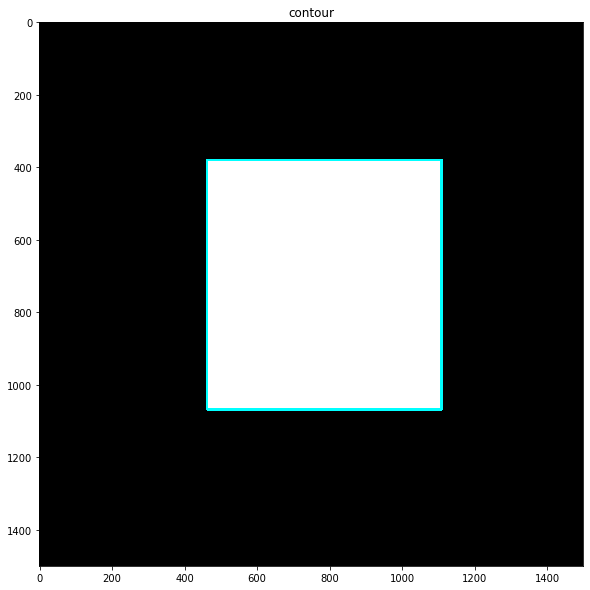

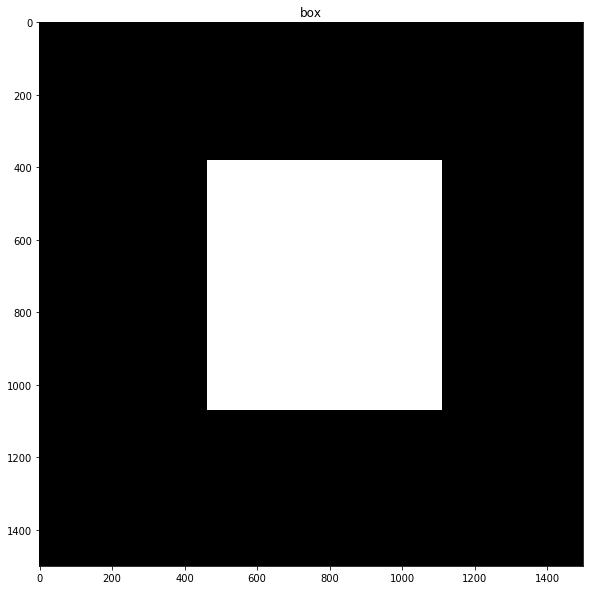

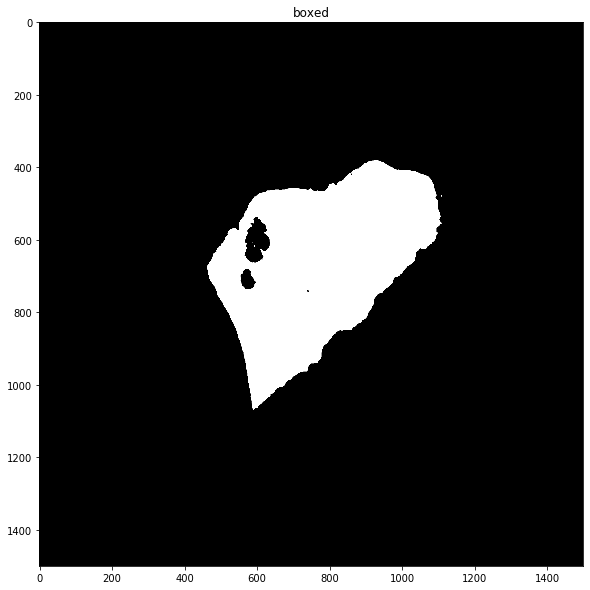

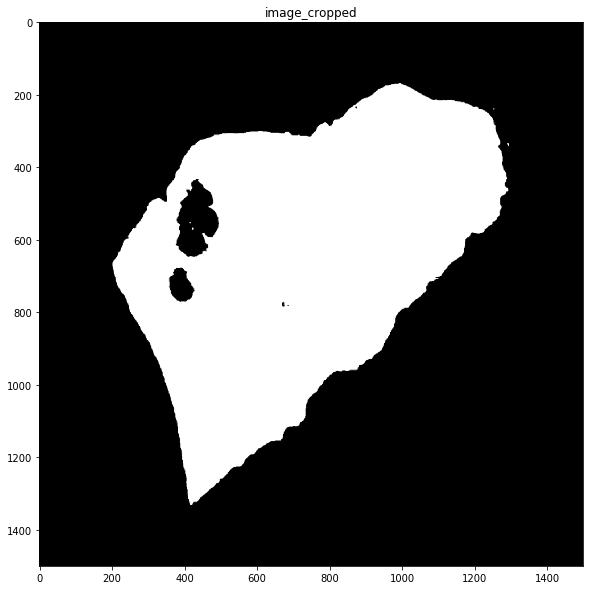

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [102]:
preprocess_block(blocks[5].copy(), True)

In [14]:
def preprocess():

    # Read all images
    import os

    path = './img/Blocks/'
    files = os.listdir(path)
    for index, file in enumerate(files):
        try:
            # convert image from BGR to RGB
            img_block = cv2.cvtColor(cv2.imread(
                os.path.join(path, file)), cv2.COLOR_BGR2RGB)
            img_block_preprocessed = preprocess_block(img_block, False)
            cv2.imwrite(
                './img/Blocks_processed/{}_blk_preprocessed.jpg'.format(index), img_block_preprocessed)
        except:
            pass

    path = './img/Slides/'
    files = os.listdir(path)
    for index, file in enumerate(files):
        try:
            # convert image from BGR to RGB
            img_slide = cv2.cvtColor(cv2.imread(
                os.path.join(path, file)), cv2.COLOR_BGR2RGB)
            img_slide_preprocessed = preprocess_slide(img_slide, False)
            cv2.imwrite(
                './img/Slides_processed/{}_sld_preprocessed.jpg'.format(index), img_slide_preprocessed)
        except:
            pass

    return

### Run the function

In [103]:
preprocess()

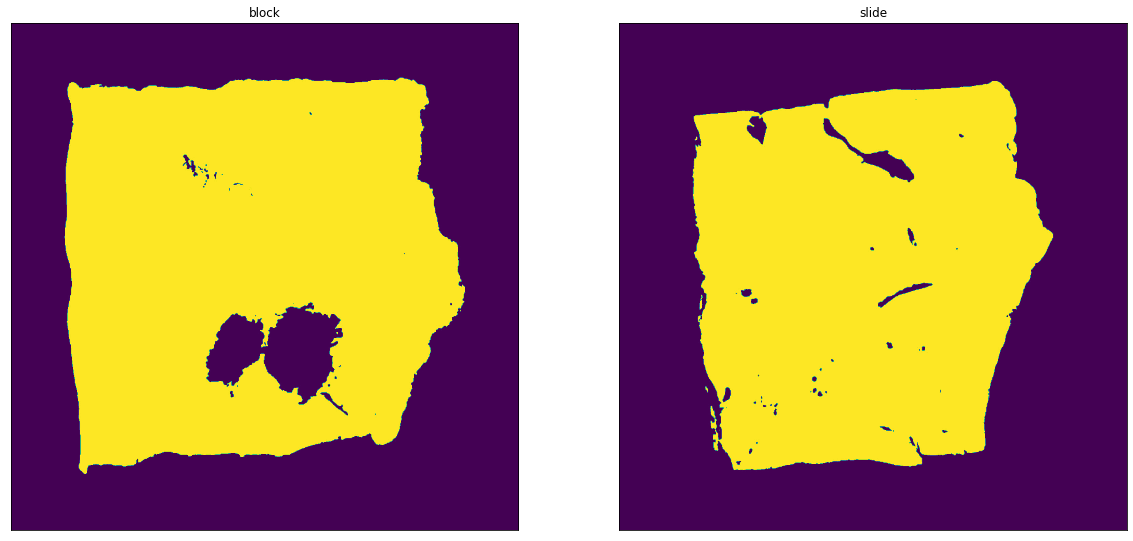

In [104]:
from pystackreg import StackReg
from skimage import io

#load reference and "moved" image

ref = cv2.cvtColor(io.imread('./img/Blocks_processed/1_blk_preprocessed.jpg'),cv2.COLOR_BGR2GRAY)
mov = cv2.cvtColor(io.imread('./img/Slides_processed/1_sld_preprocessed.jpg'),cv2.COLOR_BGR2GRAY)

show2img(ref, 'block', mov, 'slide')

In [105]:
#Translational transformation
sr = StackReg(StackReg.TRANSLATION)
out_tra = sr.register_transform(ref, mov)

#Rigid Body transformation
sr = StackReg(StackReg.RIGID_BODY)
out_rot = sr.register_transform(ref, mov)

#Scaled Rotation transformation
sr = StackReg(StackReg.SCALED_ROTATION)
out_sca = sr.register_transform(ref, mov)

#Affine transformation
sr = StackReg(StackReg.AFFINE)
out_aff = sr.register_transform(ref, mov)

#Bilinear transformation
sr = StackReg(StackReg.BILINEAR)
out_bil = sr.register_transform(ref, mov)

out_tra = out_tra.astype(np.uint8)
out_rot = out_rot.astype(np.uint8)
out_sca = out_sca.astype(np.uint8)
out_aff = out_aff.astype(np.uint8)
out_bil = out_bil.astype(np.uint8)

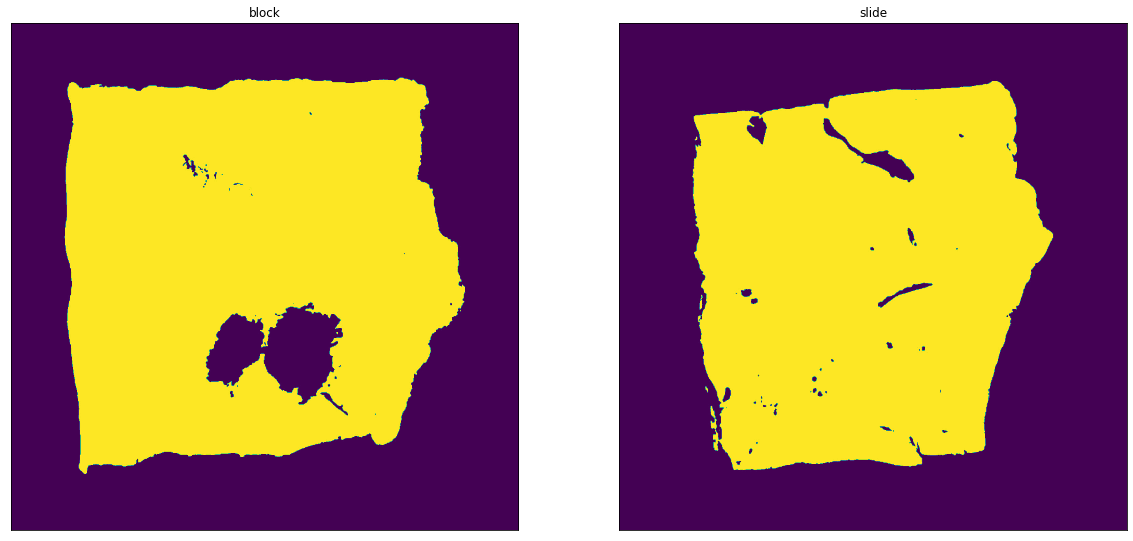

In [106]:
show2img(ref, 'block', mov, 'slide')

In [1]:
def superimpose(img_block, img_slide):

    img_block = cv2.cvtColor(img_block, cv2.COLOR_GRAY2RGB)
    img_slide = cv2.cvtColor(img_slide, cv2.COLOR_GRAY2RGB)

    img_sub_block_slide = cv2.subtract(img_block, img_slide)

    img_sub_block_slide_coloured = img_sub_block_slide.copy()
    img_sub_block_slide_coloured[img_sub_block_slide_coloured[:, :, 2] > 10] = [
        0, 0, 255]

    img_sub_slide_block = cv2.subtract(img_slide, img_block)

    img_sub_slide_block_coloured = img_sub_slide_block.copy()
    img_sub_slide_block_coloured[img_sub_slide_block_coloured[:, :, 0] > 10] = [
        255, 0, 0]
    
#     show2img(img_sub_block_slide_coloured, 'block - slide',img_sub_slide_block_coloured, 'slide - block')

    img_diff = cv2.add(img_sub_block_slide, img_sub_slide_block)
    img_diff_coloured = cv2.add(
        img_sub_block_slide_coloured, img_sub_slide_block_coloured)

    img_add = cv2.add(img_block, img_slide)
    img_same = cv2.subtract(img_add, img_diff)
#     show2img(img_same, 'img_same', img_diff_coloured, 'img_diff')

    img = cv2.addWeighted(img_diff_coloured, 0.7, img_same, 0.5, 0)
    show1img(img, 'addWeighted')

    n_white_pix_add = np.sum(img_add[:, :, 0] == 255)
    n_white_pix_same = np.sum(img_same[:, :, 0] == 255)
    n_white_pix_diff = np.sum(img_diff[:, :, 0] == 255)
    score = 1 - n_white_pix_diff/n_white_pix_add
    
    print('=========== Superimpose ===========')
    print("Superimpose: %.2f" % score)

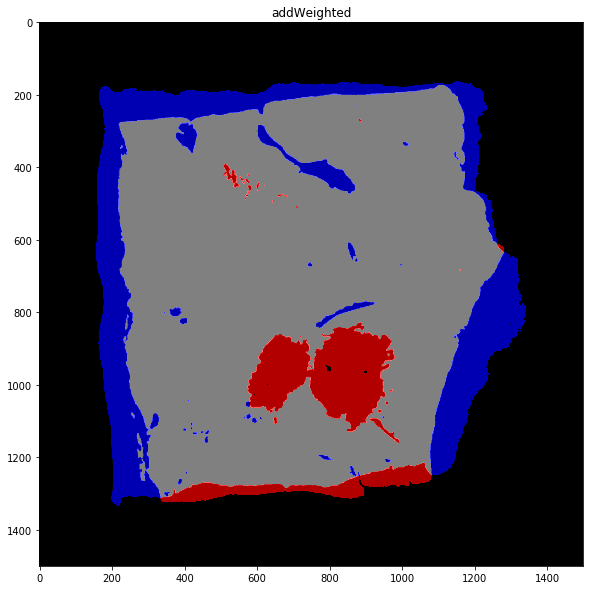

=========== Superimpose ===========
Superimpose: 0.77


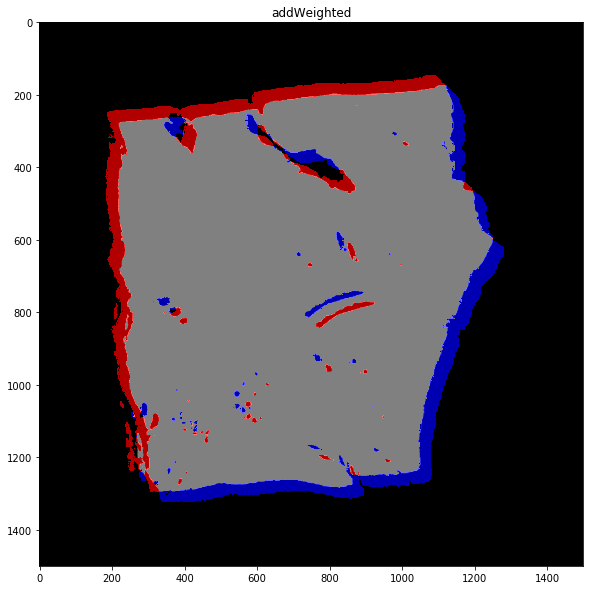

=========== Superimpose ===========
Superimpose: 0.91


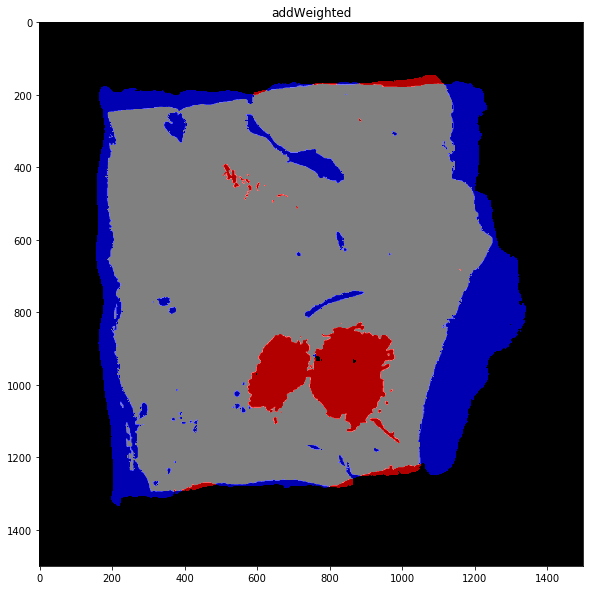

=========== Superimpose ===========
Superimpose: 0.79


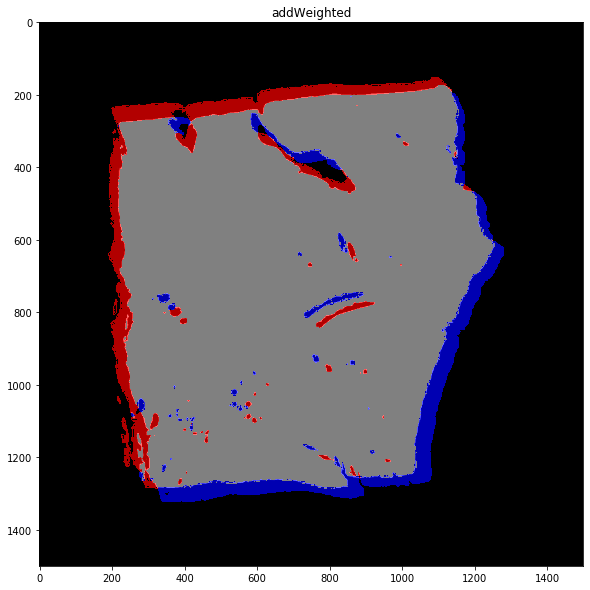

=========== Superimpose ===========
Superimpose: 0.91


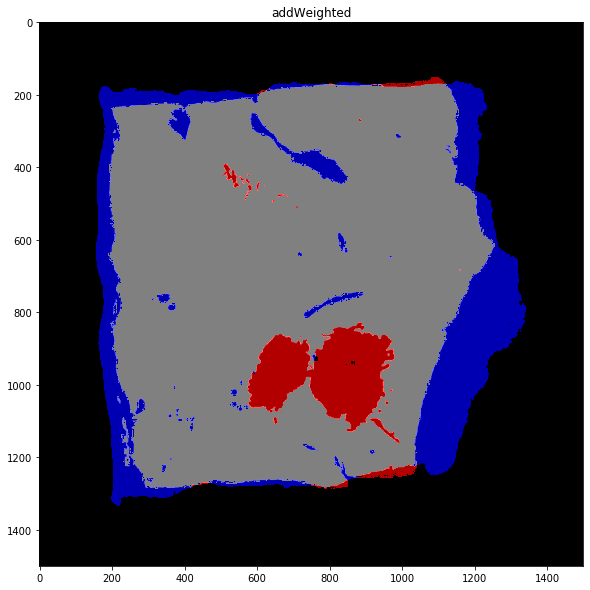

=========== Superimpose ===========
Superimpose: 0.80


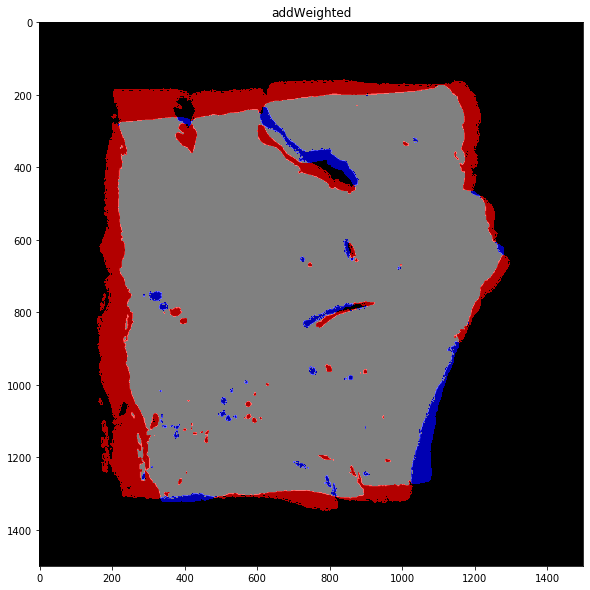

=========== Superimpose ===========
Superimpose: 0.89


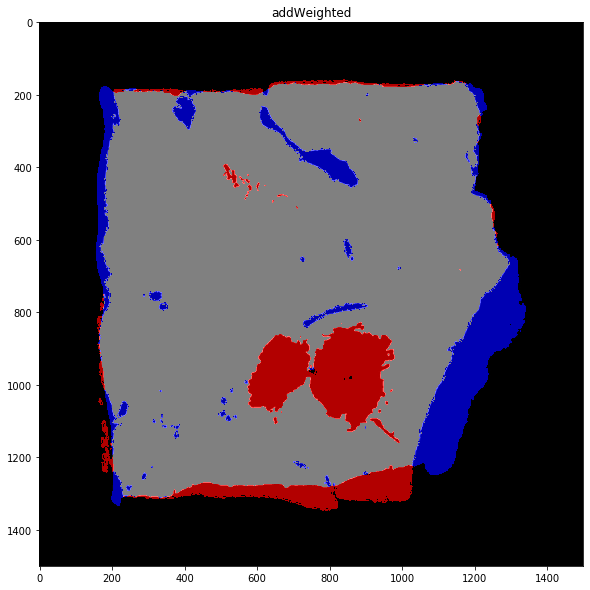

=========== Superimpose ===========
Superimpose: 0.86


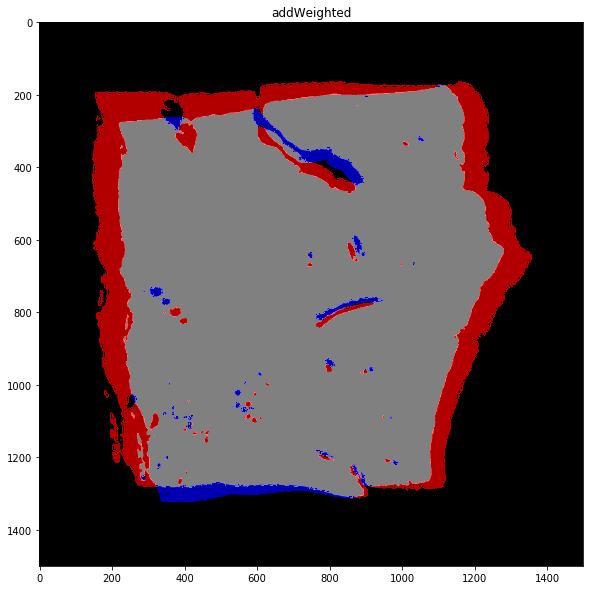

=========== Superimpose ===========
Superimpose: 0.86


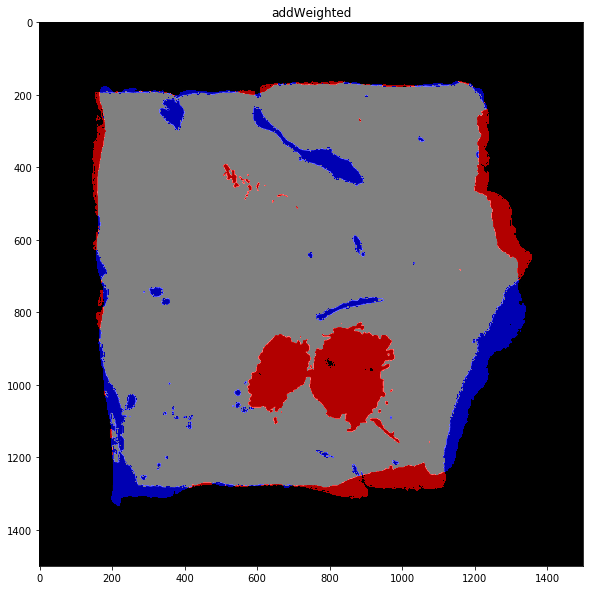

=========== Superimpose ===========
Superimpose: 0.89


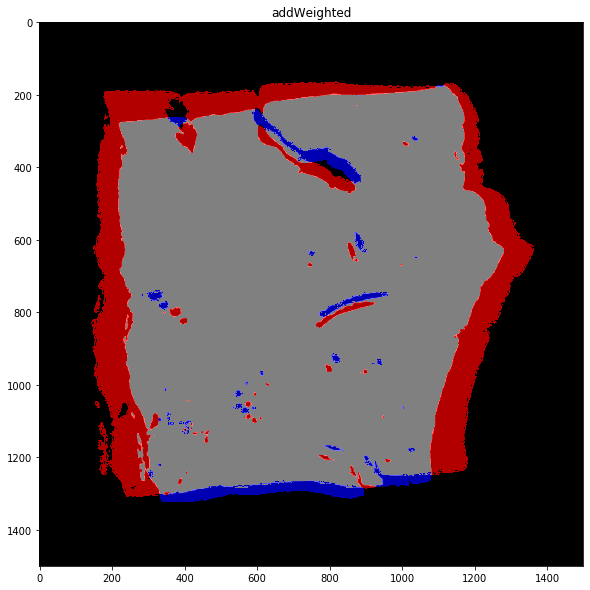

=========== Superimpose ===========
Superimpose: 0.85


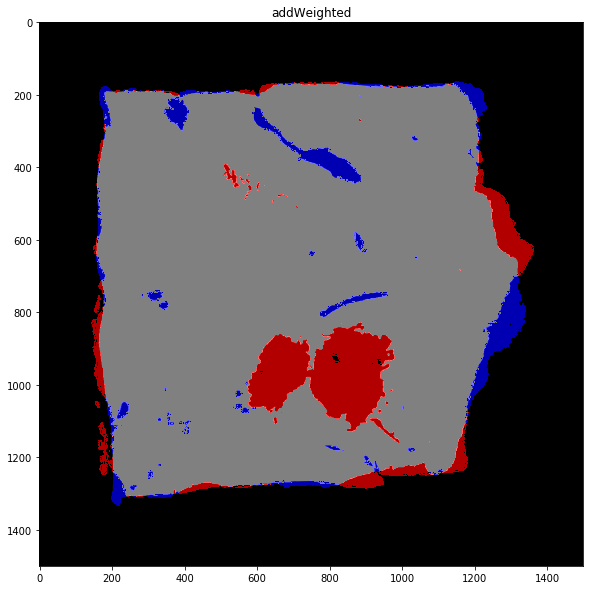

=========== Superimpose ===========
Superimpose: 0.91


In [109]:
superimpose(ref, mov)

superimpose(mov, out_tra)
superimpose(ref, out_tra)

superimpose(mov, out_rot)
superimpose(ref, out_rot)

superimpose(mov, out_sca)
superimpose(ref, out_sca)

superimpose(mov, out_aff)
superimpose(ref, out_aff)

superimpose(mov, out_bil)
superimpose(ref, out_bil)

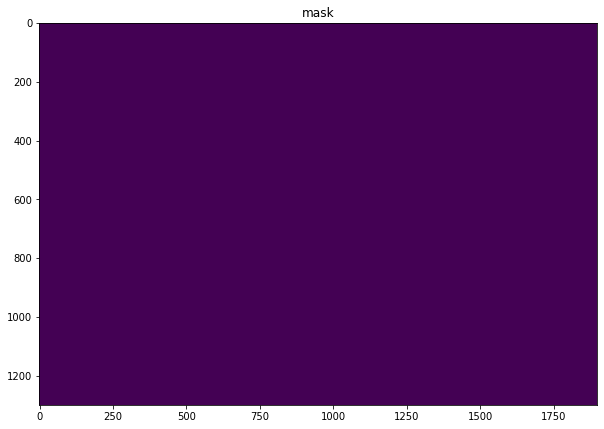

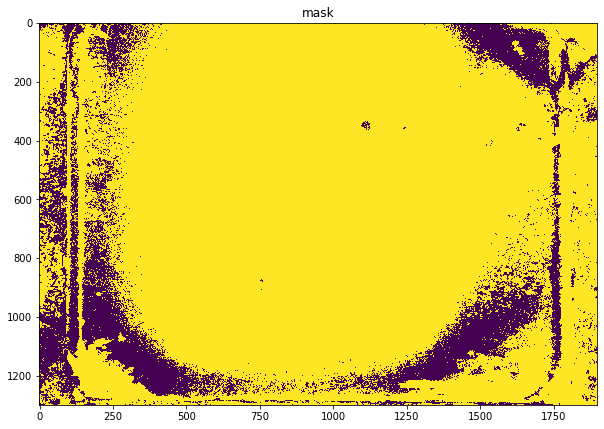

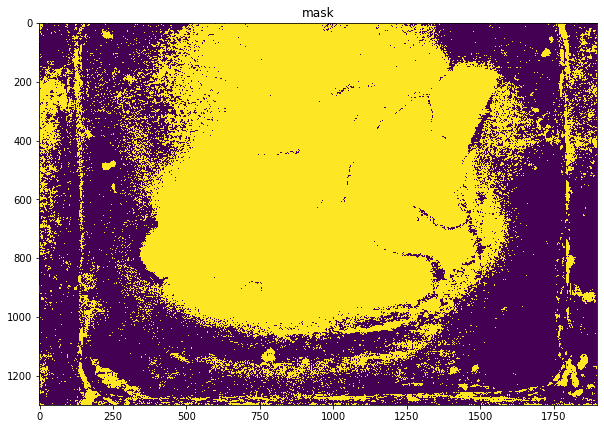

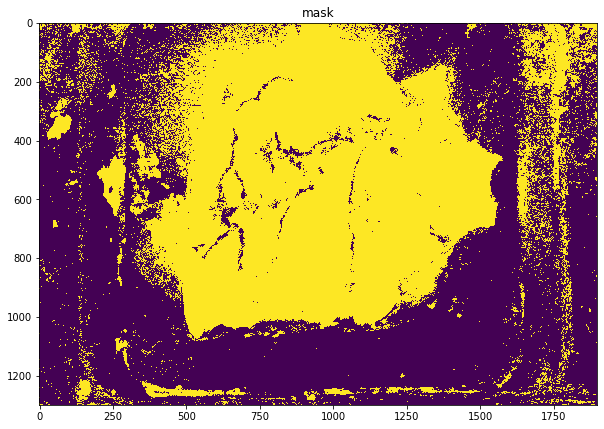

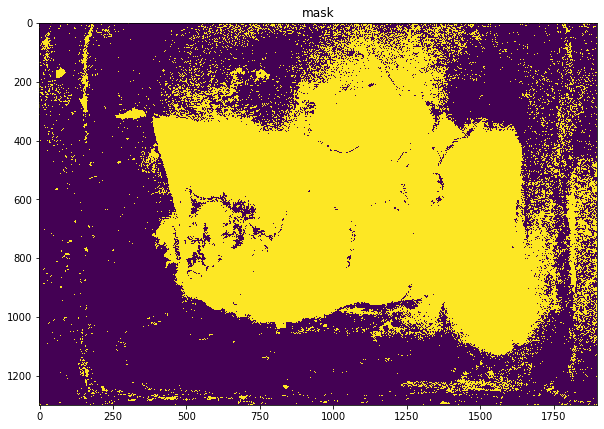

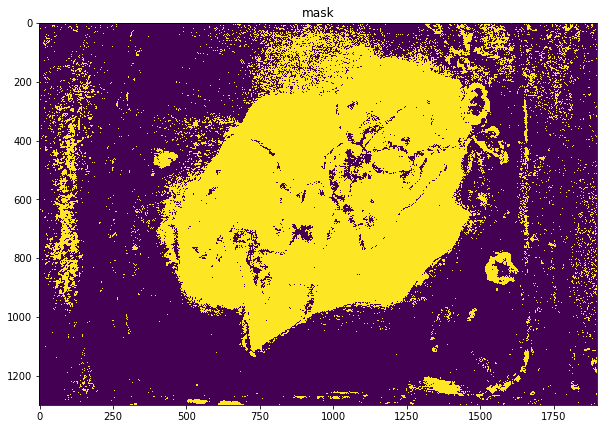

In [ ]:
subtractor = cv2.createBackgroundSubtractorMOG2(history=2, varThreshold=5, detectShadows=False)
path = './img_raw/blocks/'
files = os.listdir(path)
for index, file in enumerate(files):
    # convert image from BGR to RGB
    img_blk = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    img_blk = crop(img_blk, 1300, 3200, 1000, 2300)
    mask = subtractor.apply(img_blk)
    show1img(mask, "mask")    
    if index > 10:
        break

